In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

## Final consumption

In [2]:
fdata = pd.read_csv('fdata_ita.csv', sep = ',')
fdata.head()

,Unnamed: 0,f,fmin,fmax,f.maxF,f.maxX
0,A01,23713.831192,0,21345.327192,2.134533e+04,21345.327192
1,A02,1287.390162,0,1238.167593,7.089618e-11,0.000000
2,A03,1144.893223,0,1030.403900,1.030404e+03,1030.403900
3,B,9853.060356,0,8868.240274,6.504931e+03,6504.930858
4,C10-C12,94671.008208,0,85212.776296,3.342065e+04,33420.652971


In [3]:
f = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

## Total output

In [4]:
xdata =  pd.read_csv('xdata_ita.csv', sep = ',')
xdata.head()   

,Unnamed: 0,x,xmin,xmax,x.maxF,x.maxX
0,A01,71272.896677,0,71272.896677,42676.136170,42676.136170
1,A02,1980.006416,0,297.003455,297.003455,297.003455
2,A03,2170.824508,0,2170.824508,1471.152936,1471.152936
3,B,13515.229050,0,8850.508371,8850.508371,8850.508371
4,C10-C12,168846.903150,0,125008.417700,64382.508727,64382.508727


In [5]:
x = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [6]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x[i],6)
supply_shock = np.array(supply_shock)

# IO table 

In [7]:
df = pd.read_csv('ita_wiot.csv',sep = ',',low_memory=False)
df.head()

,Unnamed: 0,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
0,A01,0.097939,0.000113,0.001136,0.000567,0.181394,0.007495,0.002370,0.002256,8.609811e-04,...,0.000240,2.329589e-03,0.000298,5.629345e-04,0.005179,0.000612,0.000347,5.671440e-04,0.001305,0
1,A02,0.000000,0.006829,0.000425,0.000012,0.001058,0.000002,0.007682,0.002543,1.702069e-04,...,0.000034,9.502826e-07,0.000081,3.402062e-05,0.000777,0.000000,0.000000,4.429787e-08,0.000175,0
2,A03,0.000000,0.000031,0.011247,0.000000,0.000476,0.000003,0.000000,0.000000,7.126055e-07,...,0.000003,5.729112e-06,0.000006,7.411210e-07,0.000012,0.000054,0.000061,8.677816e-05,0.000281,0
3,B,0.000122,0.000017,0.000103,0.001477,0.000432,0.000359,0.000326,0.000678,5.043343e-04,...,0.001273,1.384237e-03,0.001033,8.018579e-04,0.000879,0.000136,0.000258,4.759545e-04,0.000395,0
4,C10-C12,0.073600,0.000149,0.043837,0.001451,0.225659,0.010460,0.000780,0.003053,8.387346e-04,...,0.001015,1.784083e-03,0.002589,1.158860e-03,0.001811,0.000382,0.000445,2.781864e-03,0.003419,0


In [8]:
df = df.iloc[:,1:]
df = df.astype('float')
df.shape

(55, 55)

In [9]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

## Matrix Z

In [10]:
df_Z = pd.read_csv('ita_Zmatrix.csv', sep=',', low_memory=False)
df_Z =  df_Z.iloc[:,1:]# leaving out industries U and T
df_Z = df_Z.astype('float')
df_Z.shape

(55, 55)

In [11]:
Z = np.array(df_Z)
N = Z.shape[0]
Z.shape

(55, 55)

In [12]:
som = 0
for i in range(54):
    for j in range(54):
        if Z[i][j] != 0:
            som = som+1
som/54**2

0.9945130315500685

In [13]:
x_0 = np.array(x)
x_0.shape

(55,)

In [14]:
f_0 = np.array(f)
f_0.shape

(55,)

In [15]:
L = np.linalg.inv(np.identity(N)-A)
L.shape

(55, 55)

## Direct shock

In [16]:
direct_shock = (sum(x_max)/sum(x_0),sum(f_max)/sum(f_0))
direct_shock

(0.7256416370029234, 0.8905066210075283)

# Optimization 

In [17]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return optimal_output, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [18]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [19]:
N= 54
f_max = f_max[:N]
x_max = x_max[:N]
A = A[:N,:N]
Z = Z[:N,:N]
x_0 = x_0[:N]
f_0 = f_0[:N]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:N])

## Proportional Rationing 

In [20]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t


## Mixed Rationing

In [21]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            denominator = np.matmul(A[i],d[t])
            if denominator == 0:
                r[t][i] = 1 
            else:
                r[t][i] = xmax[i]/denominator
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Priority Rationing

In [22]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [23]:
def algo_priority(A, L, fmax, xmax, ordered, TT= 30, prioritize="yes"):             
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            #return(None, None)
        #print(d[t])
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Random Rationing

In [24]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    som_x = []
    x = []
    y = []
    TT = 30
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[3] != TT:
            som_x.append(result[0])
            #som_x = sum(som_x)/len(sum_x)
            x.append(result[1])
            y.append(result[2])
    return sum(som_x)/len(som_x), sum(x)/len(x), sum(y)/len(y)

# Effect Network Density

## Eliminate Random Links

In [25]:
from random import randrange
def eliminate_rand(A, x, f, desired_density):
    Anew = A
    Znew = Z
    zeros = np.sum(Anew==0)
    indices_x = []
    indices_y = []
    if desired_density != 1:
        sparselink = round((N**2)*(1-desired_density) - np.sum(Anew==0)) # number of links we need to remove to get desired density
        #print("Sparselink: {0}".format(sparselink))
        while(np.sum(Znew==0)) < sparselink + zeros: 
            random_x = randrange(N)
            random_y = randrange(N)
            while Znew[random_x,random_y] == 0:
                random_x = randrange(N)
                random_y = randrange(N)
           
            Znew[random_x, random_y] = 0
            
            
    xnew = np.sum(Znew, axis=1) + f
    for i in range(0,N):
        for j in range(0,N):
            Anew[i][j] = Znew[i][j]/x[j]
    Lnew = np.linalg.inv(np.identity(N)-Anew)
    
    return xnew, Anew, Lnew, Znew

### Direct shock

**For 50 different densities, we adapt our matrix. We compute xnew, Anew, xmaxnew. Then we apply the shocks to the new data: instead of sum(xmax)/sum(x) it is now equal to sum(xmaxnew)/sum(xnew).**

In [26]:
densseq = np.linspace(0,1,50)

In [27]:
resdir_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        resdir_x[i][j] = (sum(xmaxnew)/sum(newdat[0]))
resdir_x = np.mean(resdir_x, axis = 1)

## Proportional rationing

In [28]:
resprop_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_proportional(newdat[1], newdat[2], f_max, xmaxnew, TT, prioritize = "no")
        if result[3]!= 30:
            resprop_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprop_x[i][j] = np.nan
resprop_x = np.mean(resprop_x, axis = 1)

## Priority

In [29]:
resprior_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}".format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        names_ordered = order(newdat[1],newdat[2],f_max)
        
        result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT=30, prioritize="yes")
        if result[3] != 30:
            resprior_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprior_x[i][j] = np.nan
        
resprior_x = np.nanmean(resprior_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


## Mixed

In [30]:
resmixed_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
N = 54
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_mixed(newdat[1], newdat[2], f_max, xmaxnew, TT,prioritize="yes")
        if result[3] != 30:
            resmixed_x[i][j] = (result[0]/sum(newdat[0]))
        else: 
            resmixed_x[i][j] = np.nan
resmixed_x = np.nanmean(resmixed_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


## Random Rationing 

In [31]:
resrandom_x = np.ones((50,50))
densseq = np.linspace(0,1,50)
runs_random = 30
runs_dens = 50
N = 54
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_random(newdat[1], newdat[2], f_max, xmaxnew, runs_random, prioritize = "random")
        resrandom_x[i][j] = result[0]/sum(newdat[0])
resrandom_x = np.mean(resrandom_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


## Optimization

In [32]:
resmax_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = max_output(N,newdat[2],newdat[1],xmaxnew,f_max)
        resmax_x[i][j] = (result[0]/sum(newdat[0]))
resmax_x = np.mean(resmax_x, axis = 1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


# Results

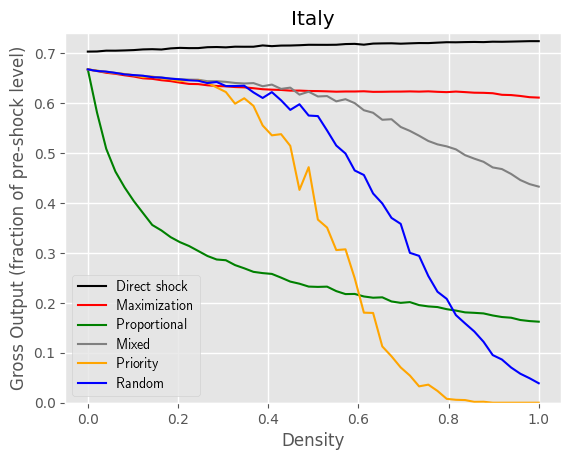

In [33]:
plt.style.use('ggplot')
plt.title("Italy")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(densseq, resdir_x, 'black')
plt.plot(densseq, resmax_x, 'red')
plt.plot(densseq, resprop_x, 'green')
plt.plot(densseq, resmixed_x, 'grey')
plt.plot(densseq, resprior_x, 'orange')
plt.plot(densseq, resrandom_x, 'blue')


#plt.xlim(-0.05, 1) 
plt.ylim(-0.00,0.74)
plt.rcParams['text.usetex'] = True
plt.xlabel('Density')
plt.ylabel("Gross Output (fraction of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_italy_density.png')